## 在KITTI数据集上评估我的定位方法的效果

KITTI Object 文件目录结构

* object/
    - training/（**NOTE：本程序使用这部分数据**）
        - calib/
            - 00000.txt
            - 00001.txt
            - ...
            - 07480.txt
            
        - image_2/
            - 00000.png
            - 00001.png
            - ...
            - 07480.png
            
        - label_2/
            - 00000.txt
            - 00001.txt
            - ...
            - 07480.txt
            
    - testing/  (**NOTE: 文件夹下没有 label_2 这个目录，需要自己生成标签文件，然后上传到服务器评估**)
        - calib/
            - 00000.txt
            - 00001.txt
            - ...
            - 07510.txt
            
        - image_2/
            - 00000.png
            - 00001.png
            - ...
            - 07510.png

In [3]:
import os
import cv2
import json

### 将定位结果保存成文件

In [4]:
"""
行人3D定位部分，不涉及到 FairMOT 的代码，而是单独写的这部分代码，直接利用KITTI数据集 ——
    行人 bbox、
    行人高度、
    内参矩阵的 fx和fy、
    图片分辨率

我需要清楚的是：一个 calib_xxxxx.txt，对应一张图片 img_xxxxx.png，对应多个行人==多个行人标签
"""


data_dir = '/mnt/sdb/public/data/kitti/object/training'
label_dir = os.path.join(data_dir, 'label_2')
img_dir = os.path.join(data_dir, 'image_2')
calib_dir = os.path.join(data_dir, 'calib')

# square_dists = [100, 400, 900, 1600, 2500]
square_dists = [25, 100, 225, 400, 625, 900, 1600, 2500]
# flag2interval = {
#         0: 'd00_10',
#         1: 'd10_20',
#         2: 'd20_30',
#         3: 'd30_40',
#         4: 'd40_50',
#         5: 'd_gt_50'
#     }
flag2interval = {
        0: 'd00_05', # 2.5
        1: 'd05_10',  # 8
        2: 'd10_15',  # 12.5
        3: 'd15_20',  # 17.5
        4: 'd20_25',  # 22.5
        5: 'd25_30',  # 27.5
        6: 'd30_40',  # 35
        7: 'd40_d50',
        8: 'd_gt_50'
    }

# count = 0
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
#         count += 1

        begin, end = 0, label_file.find('.')
        img_name = label_file[begin:end] + '.png'
        
        img = cv2.imread(os.path.join(img_dir, img_name))
        img_height, img_width, _ = img.shape
        
        img_x_center, img_y_center = img_width/2, img_height/2
        

#         print('calib_dir:', calib_dir)
#         print('calib_file:', calib_file)
        with open(os.path.join(label_dir, label_file)) as f_label, open(os.path.join(calib_dir, label_file)) as f_calib:
            fx = None
            fy = None
            lines = f_calib.readlines()
            for line in lines:
                if "P2:" in line:
                    values = line.strip().split(' ')
                    if len(values) > 0:
                        fx = float(values[1])
                        fy = float(values[6])
                    break
            
            
            ltrb = None
            H = None
            H_normal = None
            xyz = None
            
            """
            results存放计算ground-truth和对应的计算结果，一张图片可能有多个行人，所以要设计成这样
            
            {
                person_id: {'gt': ..., 'computed': ...}  
                ...
                ...
            }
            注：一个文件可能包含多个Pedestrian，这里person_id就是Pedestrian所在文件的行数，从0开始
            """
            results = {}
            
            lines = f_label.readlines()
            for idx, line in enumerate(lines):
                values = line.strip().split(' ')
                if len(values) > 0 and values[0] == 'Pedestrian':
                    results[idx] ={}
                    
                    # bbox of pedestrian in image plane
                    ltrb = values[4:8]
                    bbox_x_center = (float(ltrb[0]) + float(ltrb[2]))/2
                    bbox_y_center = (float(ltrb[1]) + float(ltrb[3]))/2
                    h = float(ltrb[3]) - float(ltrb[1])
                    
                    if h >= 40:
                        mode = 'easy'
                    elif h >= 25 and h < 40:
                        mode = 'moderate'
                    else:
                        mode = 'hard'
                    results[idx]['mode'] = mode
                    
                    """
                    解决单目物体尺度歧义性 --> pedestrian height: 
                    有两种选择，1）是高斯分布的均值1.7m，2）是直接从KITTI文件读取行人高度
                    注：因为我要在KITTI数据集评估，它本身提供了行人身高这个值，所以直接读取这个值进行计算
                        当数据集没有提供行人准确身高这个数值时，使用高斯分布的均值代入，这两种方法我都实验了效果，
                        差距并不大，实验证明使用准确的行人身高，定位误差会更小一些，与实际相符
                    """
#                     option 1:
                    H = float(values[8])
                    H_normal = 1.7
#                     option 2:
#                     H = 1.7

                    # ground-truth pedestrian position in camera coordiante
                    xyz = values[11:14]
                    
                    square_dist = float(xyz[0])**2 + float(xyz[1])**2 + float(xyz[2])**2
                    flag = -1
                    for i,elem in enumerate(square_dists):
                        if square_dist < elem:
                            flag = i
                            break
                    if flag == -1:
                        flag = len(square_dists)
                    interval = flag2interval[flag]
                    
                    results[idx]['interval'] = interval
                    
                    computed_x = fy/fx * H * (bbox_x_center-img_x_center) / h
                    computed_y = H * (bbox_y_center-img_y_center) / h
                    computed_z = H * fy / h
                    
                    computed_x_normal = fy/fx * H_normal * (bbox_x_center-img_x_center) / h
                    computed_y_normal = H_normal * (bbox_y_center-img_y_center) / h
                    computed_z_normal = H_normal * fy / h
                    print(label_file, '> ground-truth:', xyz[0], xyz[1], xyz[2])
#                     print(label_file, '> computed:', '{:.2f}'.format(computed_x), '{:.2f}'.format(computed_y), '{:.2f}'.format(computed_z))
                    
#                     results['gt'] = [float(xyz[0]), float(xyz[1]), float(xyz[2])]
                    results[idx]['gt'] = xyz
                    results[idx]['computed'] = ['{:.2f}'.format(computed_x), '{:.2f}'.format(computed_y), '{:.2f}'.format(computed_z)]
                    results[idx]['computed_normal'] = ['{:.2f}'.format(computed_x_normal), '{:.2f}'.format(computed_y_normal), '{:.2f}'.format(computed_z_normal)]
                                        
            if len(results) != 0:
#                 result_name = label_file[begin:end] + '.json'
                result_name = label_file[begin:end] + '.json'
                with open(os.path.join(data_dir, 'localization', result_name), 'w') as f_result:
                    json.dump(results, f_result)

006159.txt > ground-truth: -8.53 1.73 22.91
001758.txt > ground-truth: -4.29 1.51 7.41
003786.txt > ground-truth: 4.47 1.43 9.24
002885.txt > ground-truth: 5.73 1.43 19.81
007157.txt > ground-truth: 2.30 1.49 3.08
001049.txt > ground-truth: 3.05 1.49 8.49
001049.txt > ground-truth: -7.72 1.34 17.38
001049.txt > ground-truth: -6.79 1.33 17.94
001049.txt > ground-truth: -5.96 1.36 17.05
001049.txt > ground-truth: -3.36 1.47 13.52
001049.txt > ground-truth: -2.60 1.38 14.27
001049.txt > ground-truth: -6.22 1.43 14.19
001049.txt > ground-truth: -5.53 1.41 14.74
001049.txt > ground-truth: -4.97 1.38 15.24
001049.txt > ground-truth: -6.69 1.34 16.37
003502.txt > ground-truth: 1.54 0.68 22.32
003502.txt > ground-truth: -5.64 1.24 11.72
003502.txt > ground-truth: 3.05 1.60 4.71
003502.txt > ground-truth: 2.21 1.54 4.82
003502.txt > ground-truth: 4.15 1.00 18.36
003502.txt > ground-truth: 0.10 1.46 5.23
003502.txt > ground-truth: 0.38 1.51 6.21
003502.txt > ground-truth: 0.82 1.50 6.45
003502.t

004251.txt > ground-truth: 0.19 1.66 25.16
000789.txt > ground-truth: -2.39 1.51 8.28
002618.txt > ground-truth: 5.46 1.41 9.44
005784.txt > ground-truth: 4.62 1.44 15.97
002059.txt > ground-truth: -0.51 1.47 8.96
003700.txt > ground-truth: 4.57 1.40 7.68
000422.txt > ground-truth: -3.96 1.65 6.12
000422.txt > ground-truth: -4.53 1.64 6.12
000422.txt > ground-truth: 1.20 1.13 17.48
000422.txt > ground-truth: -4.36 1.19 26.51
000422.txt > ground-truth: -3.78 1.18 26.72
000422.txt > ground-truth: -7.93 1.21 23.93
005812.txt > ground-truth: -2.54 1.41 19.01
003264.txt > ground-truth: 3.02 1.64 11.76
006381.txt > ground-truth: -0.76 1.68 40.71
003703.txt > ground-truth: -2.43 1.49 9.17
004797.txt > ground-truth: 1.65 1.44 8.99
003020.txt > ground-truth: -6.33 1.62 16.03
003020.txt > ground-truth: -11.24 1.71 21.34
003020.txt > ground-truth: -5.55 1.58 26.70
006952.txt > ground-truth: 5.37 1.49 21.94
001169.txt > ground-truth: 1.08 1.37 12.99
001169.txt > ground-truth: 5.80 1.06 17.56
00116

001404.txt > ground-truth: 4.61 1.25 7.91
001404.txt > ground-truth: 1.83 1.27 38.96
001404.txt > ground-truth: 2.26 1.36 39.67
001404.txt > ground-truth: -0.75 1.30 55.29
003718.txt > ground-truth: 1.79 1.51 6.54
003718.txt > ground-truth: 4.61 1.29 8.51
003718.txt > ground-truth: 6.02 1.30 8.19
003718.txt > ground-truth: -2.21 1.41 17.35
003718.txt > ground-truth: -2.84 1.37 17.35
003718.txt > ground-truth: -0.77 1.33 19.14
003718.txt > ground-truth: -0.16 1.22 26.98
003718.txt > ground-truth: 0.55 1.27 19.00
003718.txt > ground-truth: 2.76 1.09 23.04
003718.txt > ground-truth: -3.03 1.35 20.35
003718.txt > ground-truth: 1.04 1.23 20.89
003379.txt > ground-truth: 7.43 1.46 25.56
003379.txt > ground-truth: 8.16 1.44 25.56
005696.txt > ground-truth: -3.78 1.53 5.16
005696.txt > ground-truth: -2.36 1.66 32.38
005696.txt > ground-truth: -1.66 1.51 32.08
005696.txt > ground-truth: 13.81 1.89 32.01
005696.txt > ground-truth: 14.84 2.31 31.56
002334.txt > ground-truth: -2.70 1.47 8.93
00693

000827.txt > ground-truth: -2.92 1.48 8.54
003339.txt > ground-truth: 0.70 1.53 7.05
005234.txt > ground-truth: 3.43 1.47 24.37
007052.txt > ground-truth: 16.76 1.20 50.23
004960.txt > ground-truth: 2.64 0.10 69.73
003124.txt > ground-truth: 3.21 1.56 29.02
002379.txt > ground-truth: -2.20 1.64 20.39
002379.txt > ground-truth: -2.69 1.63 20.15
002379.txt > ground-truth: 1.36 1.70 31.86
002379.txt > ground-truth: 2.21 1.76 31.79
006639.txt > ground-truth: 4.40 1.66 8.73
002327.txt > ground-truth: -3.32 1.43 17.58
002327.txt > ground-truth: -3.84 1.43 17.31
002327.txt > ground-truth: -7.54 1.21 29.05
004594.txt > ground-truth: -0.42 1.45 8.67
001979.txt > ground-truth: 4.18 1.55 15.74
001911.txt > ground-truth: -0.43 1.50 8.92
001911.txt > ground-truth: -6.81 1.50 8.85
004514.txt > ground-truth: -3.85 1.49 8.54
002493.txt > ground-truth: -1.80 1.46 8.47
003787.txt > ground-truth: 0.67 1.43 7.42
001029.txt > ground-truth: 2.27 1.47 7.66
001449.txt > ground-truth: 3.71 1.45 9.01
006256.txt

004268.txt > ground-truth: 1.88 1.46 4.77
004268.txt > ground-truth: 1.37 1.43 4.16
004268.txt > ground-truth: -1.10 1.36 6.63
004268.txt > ground-truth: -1.71 1.35 6.01
004268.txt > ground-truth: 2.34 1.46 5.22
004268.txt > ground-truth: -1.67 0.80 17.80
004268.txt > ground-truth: -2.22 0.53 21.87
004268.txt > ground-truth: -1.54 0.59 21.67
004268.txt > ground-truth: -0.49 0.55 21.25
005579.txt > ground-truth: -5.15 1.64 17.10
000339.txt > ground-truth: 5.56 1.46 7.95
006969.txt > ground-truth: 6.98 1.53 7.99
006969.txt > ground-truth: 5.72 1.66 18.50
006969.txt > ground-truth: 5.24 1.67 18.49
006932.txt > ground-truth: 2.89 1.61 5.74
005601.txt > ground-truth: -8.59 2.05 31.46
001982.txt > ground-truth: 3.77 1.42 8.99
002692.txt > ground-truth: 3.86 1.49 19.05
007414.txt > ground-truth: 4.04 1.43 15.31
003706.txt > ground-truth: -10.71 2.71 53.84
004398.txt > ground-truth: 10.15 1.35 20.36
007408.txt > ground-truth: 3.71 1.38 8.88
001267.txt > ground-truth: -5.04 1.55 9.52
001267.txt

001792.txt > ground-truth: 3.01 1.64 10.34
004602.txt > ground-truth: -3.48 1.78 17.79
004602.txt > ground-truth: -3.58 1.63 10.17
004602.txt > ground-truth: -3.24 1.69 13.25
004602.txt > ground-truth: 2.86 1.76 18.61
004602.txt > ground-truth: 3.43 1.72 18.68
006364.txt > ground-truth: 5.82 1.76 27.69
005793.txt > ground-truth: 0.03 1.80 29.58
005086.txt > ground-truth: 2.00 1.54 7.00
005086.txt > ground-truth: 2.93 1.55 7.17
005086.txt > ground-truth: -4.79 1.62 7.65
005086.txt > ground-truth: -2.44 1.52 12.81
005086.txt > ground-truth: 2.36 1.33 16.72
005086.txt > ground-truth: 4.94 1.33 10.84
005086.txt > ground-truth: 7.12 1.24 9.39
005086.txt > ground-truth: 6.55 1.21 11.49
005086.txt > ground-truth: -3.11 1.46 18.81
005086.txt > ground-truth: -3.97 1.46 19.16
002073.txt > ground-truth: -3.39 1.68 4.84
002073.txt > ground-truth: 5.47 1.31 11.00
007272.txt > ground-truth: -2.14 1.48 7.50
004627.txt > ground-truth: -0.56 1.59 4.84
004627.txt > ground-truth: -6.84 1.53 8.87
001817.t

000622.txt > ground-truth: -7.28 1.97 38.09
006704.txt > ground-truth: -2.25 1.63 18.05
006704.txt > ground-truth: -2.70 1.59 17.87
006704.txt > ground-truth: 5.98 1.51 12.61
006704.txt > ground-truth: 1.70 1.73 28.40
006704.txt > ground-truth: 2.55 1.73 28.42
005436.txt > ground-truth: -8.35 2.10 12.45
000746.txt > ground-truth: -6.65 1.47 8.72
004862.txt > ground-truth: 4.69 1.41 6.19
004862.txt > ground-truth: 5.26 1.39 5.92
001572.txt > ground-truth: -2.78 1.72 20.58
001572.txt > ground-truth: -3.11 1.65 14.48
001572.txt > ground-truth: 3.37 1.68 22.64
001572.txt > ground-truth: 3.94 1.62 22.72
001572.txt > ground-truth: 7.16 1.51 7.80
000330.txt > ground-truth: 4.49 1.50 27.94
003784.txt > ground-truth: 5.18 1.39 11.23
003784.txt > ground-truth: 5.55 1.47 12.30
003784.txt > ground-truth: 2.22 1.57 33.35
003784.txt > ground-truth: -8.01 1.91 14.72
002457.txt > ground-truth: -8.52 2.06 25.13
001091.txt > ground-truth: -5.46 1.52 7.17
003589.txt > ground-truth: -2.46 1.62 6.44
003589

002156.txt > ground-truth: 2.81 1.47 3.99
002156.txt > ground-truth: 2.21 1.47 3.40
002156.txt > ground-truth: 0.17 1.40 5.85
002156.txt > ground-truth: -0.47 1.41 5.29
002156.txt > ground-truth: 0.75 1.42 6.36
002156.txt > ground-truth: -1.04 0.89 16.17
002156.txt > ground-truth: -1.94 1.16 20.08
002156.txt > ground-truth: -1.31 0.66 20.05
002156.txt > ground-truth: -0.06 0.63 19.96
003183.txt > ground-truth: 2.50 -0.06 68.58
001050.txt > ground-truth: -14.34 1.41 27.82
004963.txt > ground-truth: 1.60 1.49 7.97
004963.txt > ground-truth: 2.66 1.45 8.35
004963.txt > ground-truth: -5.53 1.54 11.57
004963.txt > ground-truth: 0.73 1.36 17.01
004963.txt > ground-truth: 2.96 1.31 11.34
004963.txt > ground-truth: 5.29 1.38 7.14
004963.txt > ground-truth: 6.17 1.27 8.73
004963.txt > ground-truth: -3.87 1.47 12.34
004963.txt > ground-truth: -4.54 1.49 12.33
004963.txt > ground-truth: 6.65 1.21 9.25
004428.txt > ground-truth: -1.76 1.64 27.41
002471.txt > ground-truth: 3.71 1.53 5.40
002471.txt

002537.txt > ground-truth: 2.94 1.64 3.20
006666.txt > ground-truth: -5.28 1.51 7.10
003024.txt > ground-truth: -0.11 1.48 7.28
001548.txt > ground-truth: 0.30 1.45 8.78
003377.txt > ground-truth: -2.22 1.67 19.21
003377.txt > ground-truth: -2.69 1.69 19.01
003377.txt > ground-truth: 5.94 1.55 14.06
003377.txt > ground-truth: 1.56 1.81 30.03
003377.txt > ground-truth: 2.38 1.75 30.11
001256.txt > ground-truth: -3.70 1.48 9.02
003464.txt > ground-truth: 1.40 0.68 22.25
003464.txt > ground-truth: -5.70 1.26 11.72
003464.txt > ground-truth: 2.66 1.60 3.59
003464.txt > ground-truth: 2.43 0.79 18.80
003464.txt > ground-truth: 0.59 1.54 3.99
003464.txt > ground-truth: 0.80 1.53 4.94
003464.txt > ground-truth: 1.18 1.55 5.34
003464.txt > ground-truth: 1.73 1.56 5.51
003464.txt > ground-truth: 2.19 1.51 5.88
003464.txt > ground-truth: 2.77 1.49 5.54
003464.txt > ground-truth: -1.92 1.52 5.63
003464.txt > ground-truth: -0.52 1.33 9.71
003464.txt > ground-truth: 0.81 1.27 9.86
003464.txt > groun

004605.txt > ground-truth: 2.62 1.38 8.83
000221.txt > ground-truth: 2.99 1.64 8.92
004945.txt > ground-truth: -4.92 1.64 23.97
001661.txt > ground-truth: 5.68 1.59 13.98
001661.txt > ground-truth: 5.80 1.65 23.87
001661.txt > ground-truth: 5.35 1.64 23.91
004074.txt > ground-truth: -8.08 1.54 37.95
001008.txt > ground-truth: 4.40 1.25 8.93
001008.txt > ground-truth: 4.41 0.99 17.09
003646.txt > ground-truth: 3.55 1.70 20.81
005077.txt > ground-truth: 5.37 1.43 10.09
003324.txt > ground-truth: -0.19 1.22 23.91
003324.txt > ground-truth: -0.72 1.27 23.78
006222.txt > ground-truth: -0.53 1.46 8.35
001779.txt > ground-truth: -7.76 1.80 23.81
000337.txt > ground-truth: -3.50 1.49 8.98
003260.txt > ground-truth: -4.67 1.65 27.32
005213.txt > ground-truth: 2.39 1.55 18.14
005213.txt > ground-truth: 1.95 1.56 19.88
005213.txt > ground-truth: -5.68 1.72 17.62
007185.txt > ground-truth: 6.03 1.57 19.07
002739.txt > ground-truth: -0.64 1.41 10.74
006152.txt > ground-truth: -5.64 1.49 7.42
006579

006303.txt > ground-truth: -6.83 1.81 21.51
006303.txt > ground-truth: -7.12 1.85 22.06
003059.txt > ground-truth: 1.85 1.46 8.26
002613.txt > ground-truth: -4.15 1.54 15.42
002613.txt > ground-truth: -6.64 1.67 13.79
000726.txt > ground-truth: 1.39 1.44 8.81
000348.txt > ground-truth: 4.66 1.63 28.15
006453.txt > ground-truth: 1.75 1.45 20.14
006453.txt > ground-truth: 2.36 1.44 20.22
006453.txt > ground-truth: -2.89 1.36 19.48
001958.txt > ground-truth: -4.81 1.61 31.72
001958.txt > ground-truth: -4.08 1.32 31.33
001958.txt > ground-truth: 11.36 1.62 32.38
001958.txt > ground-truth: 12.39 1.96 31.92
001319.txt > ground-truth: -3.44 1.61 14.71
001940.txt > ground-truth: -11.02 1.36 32.04
001987.txt > ground-truth: -1.30 1.76 63.24
001426.txt > ground-truth: 3.71 1.68 7.06
001426.txt > ground-truth: -14.88 1.79 23.68
001426.txt > ground-truth: -15.83 1.84 31.55
001384.txt > ground-truth: 4.47 1.39 7.65
000342.txt > ground-truth: -3.09 1.62 9.42
000342.txt > ground-truth: 3.96 1.59 5.32

007320.txt > ground-truth: -0.13 1.46 8.96
001300.txt > ground-truth: -2.47 1.49 7.49
000275.txt > ground-truth: 4.10 1.41 25.02
000275.txt > ground-truth: 14.45 1.35 29.28
000275.txt > ground-truth: 19.24 1.52 40.94
006573.txt > ground-truth: -5.66 1.49 9.14
002571.txt > ground-truth: -5.15 1.70 14.18
005806.txt > ground-truth: 2.86 1.44 8.91
002003.txt > ground-truth: 5.76 1.58 15.60
004014.txt > ground-truth: -6.99 1.76 18.18
004014.txt > ground-truth: -7.24 1.84 18.78
004098.txt > ground-truth: 5.10 1.36 27.79
004098.txt > ground-truth: 5.75 1.34 27.48
006190.txt > ground-truth: 7.77 1.44 16.99
006190.txt > ground-truth: 8.46 1.41 16.77
002893.txt > ground-truth: -3.91 1.59 6.46
001036.txt > ground-truth: -4.40 1.50 7.29
000522.txt > ground-truth: 6.68 1.55 18.49
000522.txt > ground-truth: 11.17 1.52 22.39
000522.txt > ground-truth: 14.34 1.56 20.80
000522.txt > ground-truth: 19.10 1.68 32.29
002117.txt > ground-truth: 1.85 1.47 7.75
001286.txt > ground-truth: 9.48 0.76 16.14
00347

006926.txt > ground-truth: -3.07 1.65 5.87
006926.txt > ground-truth: 2.62 1.65 30.70
007387.txt > ground-truth: -2.62 1.48 8.14
002110.txt > ground-truth: -11.41 3.37 52.10
004773.txt > ground-truth: -8.85 2.19 42.44
002839.txt > ground-truth: -4.49 1.68 5.92
000445.txt > ground-truth: 2.95 1.59 7.20
004508.txt > ground-truth: -1.64 1.43 8.56
002420.txt > ground-truth: 5.36 1.34 15.41
004179.txt > ground-truth: 5.22 1.69 18.95
000910.txt > ground-truth: -8.40 2.08 14.60
003233.txt > ground-truth: -4.66 1.51 10.87
003233.txt > ground-truth: -5.03 1.47 11.52
005085.txt > ground-truth: -5.10 1.67 8.14
005085.txt > ground-truth: -4.99 1.65 8.72
004411.txt > ground-truth: -3.27 1.72 13.93
004271.txt > ground-truth: 0.33 1.57 6.55
004271.txt > ground-truth: -1.72 1.62 5.94
004271.txt > ground-truth: 3.19 1.47 5.49
005494.txt > ground-truth: -3.05 1.63 8.95
007004.txt > ground-truth: 7.27 1.17 19.46
007004.txt > ground-truth: 7.86 1.13 19.84
000712.txt > ground-truth: -12.15 2.60 51.20
00649

004786.txt > ground-truth: -4.60 1.54 9.48
004786.txt > ground-truth: -5.23 1.54 9.11
004786.txt > ground-truth: -2.34 1.53 7.60
004786.txt > ground-truth: 5.52 1.41 34.09
004786.txt > ground-truth: 6.17 1.40 33.30
004786.txt > ground-truth: 21.27 1.52 29.44
004786.txt > ground-truth: 22.22 1.84 28.82
007046.txt > ground-truth: 2.73 1.70 25.23
001487.txt > ground-truth: -0.90 1.29 22.67
001487.txt > ground-truth: -1.47 1.33 22.46
003887.txt > ground-truth: 4.59 1.56 30.34
000442.txt > ground-truth: 15.78 1.45 25.96
006071.txt > ground-truth: 2.91 1.25 10.93
006071.txt > ground-truth: 2.36 0.87 19.63
005654.txt > ground-truth: 4.47 1.50 20.00
002671.txt > ground-truth: 4.51 1.43 7.72
003694.txt > ground-truth: -2.28 1.50 7.09
005217.txt > ground-truth: 4.99 1.53 6.35
005218.txt > ground-truth: -2.64 1.46 7.25
000870.txt > ground-truth: 8.42 1.58 11.05
000870.txt > ground-truth: -3.24 1.77 27.32
003687.txt > ground-truth: 3.96 1.69 23.54
003687.txt > ground-truth: 4.41 1.55 24.25
003687.

006847.txt > ground-truth: 2.70 1.11 31.67
003267.txt > ground-truth: -6.71 1.84 23.73
003267.txt > ground-truth: -7.04 1.85 24.24
005568.txt > ground-truth: -2.17 1.45 10.41
005568.txt > ground-truth: -8.46 1.20 17.42
005568.txt > ground-truth: -10.22 1.21 15.75
005568.txt > ground-truth: -14.04 0.89 22.16
005568.txt > ground-truth: -10.60 1.14 15.92
005568.txt > ground-truth: -11.91 1.00 21.31
005568.txt > ground-truth: -12.65 0.94 20.99
005568.txt > ground-truth: -11.51 0.99 25.16
005568.txt > ground-truth: -12.57 0.92 25.71
005568.txt > ground-truth: -13.17 0.90 25.88
005568.txt > ground-truth: -13.85 0.93 25.85
005568.txt > ground-truth: -16.46 0.72 30.94
000695.txt > ground-truth: 2.03 1.37 8.66
001394.txt > ground-truth: 3.18 1.44 7.83
002999.txt > ground-truth: 9.93 0.91 12.41
002999.txt > ground-truth: 10.06 0.99 11.72
000189.txt > ground-truth: 1.14 1.17 10.61
000189.txt > ground-truth: -0.83 0.91 14.81
000189.txt > ground-truth: 0.05 0.92 14.98
000189.txt > ground-truth: 1.2

004595.txt > ground-truth: 4.45 1.44 7.74
004127.txt > ground-truth: 3.66 1.73 14.99
004127.txt > ground-truth: -14.84 1.72 32.36
001368.txt > ground-truth: 4.85 1.60 31.46
004854.txt > ground-truth: -5.94 1.47 8.25
006809.txt > ground-truth: 4.22 2.17 22.42
006583.txt > ground-truth: 2.74 0.74 22.43
006583.txt > ground-truth: -5.30 1.21 11.73
006583.txt > ground-truth: 1.37 1.46 7.08
006583.txt > ground-truth: 2.34 1.42 7.33
006583.txt > ground-truth: 0.91 1.24 10.72
006583.txt > ground-truth: 0.36 1.24 10.87
006583.txt > ground-truth: 2.04 1.18 11.26
006583.txt > ground-truth: 2.97 1.16 11.37
006583.txt > ground-truth: 12.89 1.92 17.46
006583.txt > ground-truth: -1.62 1.24 10.84
006583.txt > ground-truth: -1.42 1.15 11.54
006583.txt > ground-truth: -0.92 1.17 11.84
006583.txt > ground-truth: -0.28 1.16 12.12
006583.txt > ground-truth: -0.33 1.09 12.92
006583.txt > ground-truth: -3.14 0.96 16.57
006583.txt > ground-truth: -1.68 0.90 16.90
006583.txt > ground-truth: -0.81 0.88 17.13
00

000718.txt > ground-truth: 3.22 1.39 3.33
000718.txt > ground-truth: 4.30 1.33 5.28
000718.txt > ground-truth: -1.52 1.46 10.05
000718.txt > ground-truth: -1.98 1.47 9.58
000718.txt > ground-truth: 0.51 1.22 16.55
000718.txt > ground-truth: 1.04 1.09 24.56
000718.txt > ground-truth: 1.69 1.18 16.25
000718.txt > ground-truth: 3.72 1.00 20.42
000718.txt > ground-truth: -4.10 1.40 17.09
000718.txt > ground-truth: 2.63 1.12 18.73
005688.txt > ground-truth: 5.53 1.37 9.61
005688.txt > ground-truth: 5.94 1.44 10.56
005688.txt > ground-truth: 2.24 1.58 32.25
005688.txt > ground-truth: -8.08 1.95 12.95
001547.txt > ground-truth: 4.80 1.40 8.99
006536.txt > ground-truth: -5.28 1.71 12.58
004470.txt > ground-truth: -5.31 1.47 9.08
000118.txt > ground-truth: 1.26 1.26 27.59
005617.txt > ground-truth: -1.77 1.56 4.74
005617.txt > ground-truth: -1.94 1.61 3.86
005617.txt > ground-truth: 1.00 1.31 14.61
005617.txt > ground-truth: -3.82 1.30 21.93
005617.txt > ground-truth: -4.49 1.28 22.60
005617.tx

006151.txt > ground-truth: 2.00 1.50 7.53
007447.txt > ground-truth: -0.08 1.57 20.75
004915.txt > ground-truth: -2.26 1.48 8.48
000999.txt > ground-truth: 1.95 1.58 7.46
000999.txt > ground-truth: 2.83 1.57 7.65
000999.txt > ground-truth: -5.99 1.65 7.61
000999.txt > ground-truth: -3.74 1.55 12.31
000999.txt > ground-truth: 1.55 1.43 16.97
000999.txt > ground-truth: 4.21 1.35 11.20
000999.txt > ground-truth: 6.38 1.31 8.80
000999.txt > ground-truth: 6.28 1.28 10.70
000999.txt > ground-truth: -3.59 1.52 16.81
000999.txt > ground-truth: -4.43 1.54 16.90
000999.txt > ground-truth: 7.64 1.27 9.09
004717.txt > ground-truth: 0.72 1.60 9.12
004717.txt > ground-truth: -5.97 1.93 16.67
001574.txt > ground-truth: -0.77 1.44 7.28
001167.txt > ground-truth: 5.90 1.78 31.47
003109.txt > ground-truth: 10.42 1.45 33.94
006301.txt > ground-truth: 3.86 1.38 11.07
006308.txt > ground-truth: 3.88 1.45 7.67
002718.txt > ground-truth: -4.81 1.48 9.06
001238.txt > ground-truth: -4.86 1.77 8.87
001238.txt >

001409.txt > ground-truth: 6.13 1.35 6.54
001409.txt > ground-truth: 6.29 1.42 7.19
001409.txt > ground-truth: 2.44 1.68 30.05
005208.txt > ground-truth: -4.33 2.04 38.32
006842.txt > ground-truth: -5.05 1.63 22.12
005027.txt > ground-truth: -3.83 1.44 11.73
005027.txt > ground-truth: -8.53 1.17 19.50
005027.txt > ground-truth: -10.25 1.19 15.70
005027.txt > ground-truth: -14.45 0.89 23.80
005027.txt > ground-truth: -10.61 1.14 15.82
005027.txt > ground-truth: -12.89 0.95 22.56
005027.txt > ground-truth: -13.74 0.92 22.28
005027.txt > ground-truth: -11.23 1.03 23.72
005027.txt > ground-truth: -12.22 1.00 24.33
005027.txt > ground-truth: -12.78 0.93 24.56
005027.txt > ground-truth: -13.40 0.94 24.60
005027.txt > ground-truth: -16.46 0.72 30.94
000274.txt > ground-truth: -3.21 1.97 11.22
006121.txt > ground-truth: 2.79 0.77 22.01
006121.txt > ground-truth: -5.20 1.22 11.66
006121.txt > ground-truth: 2.93 1.57 6.16
006121.txt > ground-truth: 3.10 1.40 7.14
006121.txt > ground-truth: 2.06 

002324.txt > ground-truth: 3.71 1.48 7.57
004723.txt > ground-truth: -0.55 1.44 9.73
001712.txt > ground-truth: -7.55 1.63 15.48
003250.txt > ground-truth: 5.73 1.73 23.91
004488.txt > ground-truth: -2.17 1.51 19.40
004488.txt > ground-truth: -2.02 1.63 23.87
004488.txt > ground-truth: -1.75 1.64 24.43
007182.txt > ground-truth: -4.34 1.57 15.02
007182.txt > ground-truth: -4.80 1.60 18.02
007182.txt > ground-truth: -4.45 1.59 17.52
000058.txt > ground-truth: -1.56 1.45 7.29
000532.txt > ground-truth: 2.62 1.44 9.00
006522.txt > ground-truth: 11.05 1.16 21.16
006522.txt > ground-truth: 11.52 1.08 21.42
001262.txt > ground-truth: -14.90 1.63 20.21
001262.txt > ground-truth: -15.85 1.65 28.31
005115.txt > ground-truth: 11.27 1.15 20.76
005115.txt > ground-truth: 11.81 1.09 21.04
003924.txt > ground-truth: -0.79 1.26 18.82
003924.txt > ground-truth: 0.02 1.27 18.66
003924.txt > ground-truth: -2.80 1.38 15.87
003924.txt > ground-truth: 0.10 1.45 7.68
003924.txt > ground-truth: 6.14 1.24 7.5

005824.txt > ground-truth: 3.28 1.59 5.24
005824.txt > ground-truth: 2.40 1.64 5.61
005824.txt > ground-truth: -0.29 1.77 26.62
005824.txt > ground-truth: -0.92 1.70 24.21
003146.txt > ground-truth: 5.02 1.43 22.43
003146.txt > ground-truth: 5.56 1.40 22.12
006258.txt > ground-truth: -3.45 1.49 8.70
001193.txt > ground-truth: 0.19 1.31 17.49
001193.txt > ground-truth: 0.16 1.30 16.36
001193.txt > ground-truth: 2.65 1.55 5.56
001193.txt > ground-truth: -0.47 1.37 13.18
005813.txt > ground-truth: -2.86 1.61 4.49
005813.txt > ground-truth: -3.60 1.70 14.69
005813.txt > ground-truth: -4.19 1.68 14.87
005813.txt > ground-truth: 1.52 1.75 19.18
004321.txt > ground-truth: -0.57 1.20 21.35
004321.txt > ground-truth: 0.14 1.20 21.38
004321.txt > ground-truth: -1.19 1.45 8.04
004321.txt > ground-truth: 6.15 1.26 7.57
004321.txt > ground-truth: -1.93 1.32 17.32
004321.txt > ground-truth: -0.98 1.43 10.43
004321.txt > ground-truth: 3.89 1.28 8.49
005439.txt > ground-truth: 2.73 1.49 7.41
004487.tx

005991.txt > ground-truth: -2.56 1.69 54.97
000380.txt > ground-truth: 8.44 1.58 15.11
000380.txt > ground-truth: -3.18 1.92 30.66
007077.txt > ground-truth: -2.52 1.47 8.11
005671.txt > ground-truth: -6.04 1.70 16.55
006908.txt > ground-truth: -3.24 1.66 4.27
006908.txt > ground-truth: -3.42 1.62 6.87
006908.txt > ground-truth: -4.05 1.60 6.89
006908.txt > ground-truth: 1.57 1.16 18.69
006908.txt > ground-truth: -3.51 1.26 26.91
006908.txt > ground-truth: -2.96 1.25 27.14
006908.txt > ground-truth: -7.06 1.28 24.33
001113.txt > ground-truth: 2.01 1.46 8.25
003880.txt > ground-truth: 3.92 1.34 10.32
003880.txt > ground-truth: 0.40 1.52 25.19
003880.txt > ground-truth: 1.10 1.52 25.34
003880.txt > ground-truth: -3.78 1.56 23.86
004788.txt > ground-truth: -2.96 1.09 28.83
004788.txt > ground-truth: -6.32 1.05 26.15
004788.txt > ground-truth: -7.82 1.23 27.57
007452.txt > ground-truth: -10.14 1.39 11.64
007452.txt > ground-truth: -10.12 1.42 12.28
001062.txt > ground-truth: 5.59 1.56 8.07

004524.txt > ground-truth: -8.10 1.98 38.14
002342.txt > ground-truth: -2.43 1.48 8.10
000179.txt > ground-truth: -10.77 1.86 23.51
004562.txt > ground-truth: -4.90 1.50 10.75
004562.txt > ground-truth: -0.27 1.40 15.76
004562.txt > ground-truth: -2.63 1.43 15.39
004562.txt > ground-truth: -1.49 1.35 19.32
004562.txt > ground-truth: 0.71 1.27 23.72
004562.txt > ground-truth: 0.29 1.18 30.54
004733.txt > ground-truth: -4.97 1.49 8.58
002954.txt > ground-truth: 3.40 1.59 7.34
002954.txt > ground-truth: 2.56 1.65 8.27
006262.txt > ground-truth: -3.21 1.95 24.23
001895.txt > ground-truth: 5.44 1.46 11.06
003955.txt > ground-truth: 3.54 1.59 10.50
003955.txt > ground-truth: 2.72 1.64 12.26
003763.txt > ground-truth: 1.31 1.12 15.01
003763.txt > ground-truth: -4.52 1.19 25.97
003763.txt > ground-truth: -3.91 1.20 26.13
003763.txt > ground-truth: -8.33 1.31 23.58
001357.txt > ground-truth: -1.45 1.42 11.05
001357.txt > ground-truth: -2.06 1.45 10.76
001357.txt > ground-truth: -0.10 1.42 10.12

### 评估定位结果

In [56]:
loc_dir = os.path.join(data_dir, 'localization')
def analyze_localization():
    with open(os.path.join(data_dir, 'localization', 'error_rate.json'), 'w') as fout:
        data = {}
        
        for f_name in os.listdir(loc_dir):
            if f_name.endswith('.json') and f_name != 'error_rate.json':  # 别忽略第二个条件
                f = os.path.join(loc_dir, f_name)
                with open(f) as fin:
                    results = json.load(fin)
                    data[f_name] = {}

                    for key in results.keys():
                        # convert string to float
                        gt = [ float(elem) for elem in results[key]['gt'] ]
                        computed = [ float(elem) for elem in results[key]['computed'] ]
                        # compute error
                        error = [ g-c for g,c in zip(gt, computed) ]
                        # compute error rate
                        error_rate = []
                        for e,g in zip(error, gt):
                            if g == 0:
                                error_rate.append(abs(e))
                            else:
                                error_rate.append(abs(e/g))
                        data[f_name][key] = error_rate
                        print(f_name, key, '-> error_rate:', error_rate)
                    
        json.dump(data, fout, indent=4)

In [57]:
analyze_localization()

007157.json 1 -> error_rate: [0.7260869565217394, 0.5771812080536912, 0.7272727272727273]
006301.json 7 -> error_rate: [0.023316062176165768, 0.7971014492753623, 0.02710027100271009]
006083.json 0 -> error_rate: [0.11764705882352935, 0.6518518518518519, 0.05283757338551868]
006083.json 2 -> error_rate: [0.274390243902439, 0.9150943396226415, 0.017561983471074374]
004240.json 2 -> error_rate: [0.13440860215053752, 0.7804878048780488, 0.012767066180302291]
003302.json 5 -> error_rate: [0.048739495798319335, 0.7586206896551725, 0.007727975270479108]
001371.json 6 -> error_rate: [0.12033195020746888, 0.9606741573033708, 0.010118897040222579]
003277.json 0 -> error_rate: [0.05897435897435897, 0.6643835616438356, 0.054545454545454536]
007156.json 11 -> error_rate: [0.2598425196850393, 1.2590673575129532, 0.007257291524031236]
007156.json 12 -> error_rate: [0.337313432835821, 1.2857142857142856, 0.005410523468145619]
007301.json 6 -> error_rate: [0.009389671361502356, 0.6029411764705882, 0.01

006685.json 0 -> error_rate: [0.03278688524590167, 0.6233766233766234, 0.09239940387481373]
005482.json 2 -> error_rate: [0.055693069306930715, 0.8392857142857143, 0.031353135313531275]
005482.json 3 -> error_rate: [0.059040590405904106, 0.7857142857142857, 0.029590948651000856]
001161.json 0 -> error_rate: [0.03999999999999994, 0.6688741721854304, 0.04149933065595711]
006997.json 1 -> error_rate: [0.18695652173913052, 0.5695364238410596, 0.19955654101995574]
000015.json 1 -> error_rate: [0.07999999999999997, 0.7218045112781956, 0.06587615283267458]
000015.json 2 -> error_rate: [0.16666666666666674, 0.7446808510638298, 0.021126760563380347]
000015.json 3 -> error_rate: [0.16363636363636366, 0.7714285714285714, 0.021882741535920628]
000015.json 4 -> error_rate: [0.229050279329609, 0.7867647058823529, 0.024463519313304732]
000931.json 1 -> error_rate: [0.0358514724711907, 0.8098591549295775, 0.027613412228796954]
000931.json 2 -> error_rate: [0.043580683156655003, 0.8273381294964028, 0.0

ZeroDivisionError: float division by zero

### 评估检测结果

In [ ]:
def analyze_detection():
    # 仅对有行人的图片进行检测
    for f_name in os.listdir(loc_dir):
        if f_name.endswith('.json'):
            begin, end = 0, f_name.find('.')
            img_name = f_name[begin:end]
            os.path.join()

### 用OpenCV读取照片的 宽度、长度

In [4]:
data_dir = '/mnt/sdb/public/data/kitti/object/training'
label_dir = os.path.join(data_dir, 'label_2')
img_dir = os.path.join(data_dir, 'image_2')

img = cv2.imread(os.path.join(img_dir, '000000.png'))
height, width, channels = img.shape

In [38]:
len({})

0

In [39]:
os.path.join(data_dir, 'localization', 'aaa')

'/mnt/sdb/public/data/kitti/object/training/localization/aaa'

In [5]:
%pip list

Package             Version             Location
------------------- ------------------- --------------------------------------------------------------
attrs               19.3.0
backcall            0.2.0
bibtexparser        1.2.0
bleach              3.1.5
certifi             2020.6.20
cffi                1.14.0
chardet             3.0.4
cycler              0.10.0
Cython              0.29.20
cython-bbox         0.1.3
DCNv2               0.1                 /home/jerry/iGitRepo/FairMOT/src/lib/models/networks/DCNv2_new
decorator           4.4.2
defusedxml          0.6.0
entrypoints         0.3
et-xmlfile          1.0.1
flake8              3.8.3
flake8-import-order 0.18.1
future              0.18.2
idna                2.10
importlib-metadata  1.7.0
ipykernel           5.3.4
ipython             7.16.1
ipython-genutils    0.2.0
ipywidgets          7.5.1
jdcal               1.4.1
jedi                0.17.2
Jinja2              2.11.2
joblib              0.16.0
jsonschema          3.2.0
jupyt

### 行人身高预测

#### 划分训练/测试集
* 这一步就遇到了问题，划分标准得参考之前的方法吧，73原则

In [6]:
import os
import json

data_dir = '/mnt/sdb/public/data/kitti/object/training/'

label_dir = os.path.join(data_dir, 'label_2')
img_dir = os.path.join(data_dir, 'image_2')
calib_dir = os.path.join(data_dir, 'calib')

In [7]:
heights = []

In [8]:
"""
把有行人的图片拿出来，记下每个行人框，及其高度
"""

data_dir = '/mnt/sdb/public/data/kitti/object/training'
label_dir = os.path.join(data_dir, 'label_2')
img_dir = os.path.join(data_dir, 'image_2')

results = {}

# count = 0
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
#         count += 1

        begin, end = 0, label_file.find('.')
        img_name = label_file[begin:end] + '.png'
        
#         img = cv2.imread(os.path.join(img_dir, img_name))
#         img_height, img_width, _ = img.shape                
        
        results[img_name] = {}

#         print('calib_dir:', calib_dir)
#         print('calib_file:', calib_file)
        with open(os.path.join(label_dir, label_file)) as f_label:                                                          
            """
            results存放所有图片中的行人信息：一张图片可能有多个行人，所以要设计成这样
            
            {
                image_id: {
                    'person_id': 
                    {
                        'bbox': bounding box, 
                        'height': height
                    },
                    ...
                    ...
                },
                ...
                ...
            }
            注：一个文件可能包含多个Pedestrian，这里person_id就是Pedestrian所在文件的行数，从0开始
            """
            ltrb = None
                        
            lines = f_label.readlines()
            for idx, line in enumerate(lines):
                values = line.strip().split(' ')
                if len(values) > 0 and values[0] == 'Pedestrian':
                    results[img_name][idx] ={}
                    
                    # bbox of pedestrian in image plane
                    bbox_ltrb = values[4:8]
                    height = float(values[8])
                    heights.append(height)
                    
                    results[img_name][idx]['bbox'] = [float(val) for val in bbox_ltrb]
                    results[img_name][idx]['height'] = height
            if len(results[img_name]) == 0:
                results.pop(img_name)
                                        
# if len(results) != 0:    
#     with open('ped_bbox_height.json', 'w') as f_result:
#         json.dump(results, f_result, indent=4)

In [9]:
print('len(results)', len(results))
print('len(heights)', len(heights))

height2count = {}
for height in heights:
    height = '{0:.2f}'.format(height)
    if height not in height2count.keys():
        height2count[height] = 0
    else:
        height2count[height] += 1
        
# print(height2count)
h2c = {
    'height': [float(height) for height in height2count.keys()],
    'count': [count for count in height2count.values()]
}
# print(h2c['height'],'\n')
# print(h2c['count'],'\n')

binlist = [float(height) for height in height2count.keys()]
binlist.sort()
binlist = tuple(binlist)
# print('len(binlist)', len(binlist))
# print('binlist', binlist)
print(height2count)

len(results) 1779
len(heights) 4487
{'1.88': 73, '1.76': 137, '1.73': 144, '1.71': 103, '1.50': 21, '1.79': 101, '1.89': 160, '1.77': 200, '1.84': 111, '1.70': 77, '1.92': 104, '1.81': 228, '1.80': 244, '1.62': 60, '1.85': 104, '1.56': 27, '1.63': 106, '1.78': 223, '1.67': 89, '1.82': 169, '1.75': 164, '1.66': 68, '1.91': 44, '1.96': 51, '1.65': 66, '1.61': 108, '1.83': 98, '1.87': 141, '1.52': 7, '1.64': 70, '1.74': 113, '1.59': 33, '1.60': 81, '1.68': 114, '1.18': 8, '1.72': 176, '1.95': 33, '1.93': 30, '1.54': 56, '1.69': 98, '1.55': 16, '1.49': 13, '1.51': 14, '1.86': 84, '1.94': 30, '2.00': 10, '1.97': 34, '1.58': 38, '1.90': 70, '1.53': 25, '2.01': 16, '1.57': 8, '1.99': 14, '1.48': 12, '1.14': 8}


In [10]:
import collections

odrered_h2c = collections.OrderedDict(sorted(height2count.items()))
odrered_h2c

OrderedDict([('1.14', 8),
             ('1.18', 8),
             ('1.48', 12),
             ('1.49', 13),
             ('1.50', 21),
             ('1.51', 14),
             ('1.52', 7),
             ('1.53', 25),
             ('1.54', 56),
             ('1.55', 16),
             ('1.56', 27),
             ('1.57', 8),
             ('1.58', 38),
             ('1.59', 33),
             ('1.60', 81),
             ('1.61', 108),
             ('1.62', 60),
             ('1.63', 106),
             ('1.64', 70),
             ('1.65', 66),
             ('1.66', 68),
             ('1.67', 89),
             ('1.68', 114),
             ('1.69', 98),
             ('1.70', 77),
             ('1.71', 103),
             ('1.72', 176),
             ('1.73', 144),
             ('1.74', 113),
             ('1.75', 164),
             ('1.76', 137),
             ('1.77', 200),
             ('1.78', 223),
             ('1.79', 101),
             ('1.80', 244),
             ('1.81', 228),
             ('1.8

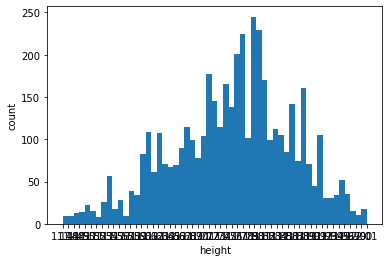

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

heights_ = ['{0:.2f}'.format(height) for height in heights]
df = pd.DataFrame(heights_, columns=['height'])
df.sort_values(by=['height'], inplace=True)

plt.hist(df['height'], bins=55)

plt.xlabel('height')
plt.ylabel('count')

plt.show()

In [12]:
df = pd.DataFrame(data=h2c, columns=['height', 'count'])

df.head()
# df

height  count
0    1.88     73
1    1.76    137
2    1.73    144
3    1.71    103
4    1.50     21

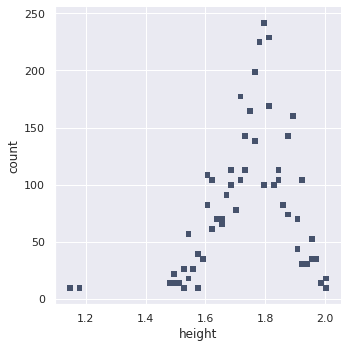

In [13]:
sns.set_theme()
sns.displot(df, x='height', y='count', bins=55)

### 从边界框提取行人特征

- 用什么提特征？有几种选项：    
    - 神经网络
    - 机器学习
- 每张图片上行人个数不一，所以不能将单张图像作为输入单元
- 行人框大小不一，要统一输入输出
* 可能有哪些特征有用？
    - 外观
    - 矩形框大小

In [14]:
import cv2 as cv

In [15]:
# 只需要把图片读出来，剩下的从results字典里取
for img_file in os.listdir(img_dir):
    if img_file.endswith('.png'):
                
        if img_file in results.keys():
            # print(img_file, results[img_file], '')
            pass
#         break

#### 样例图片

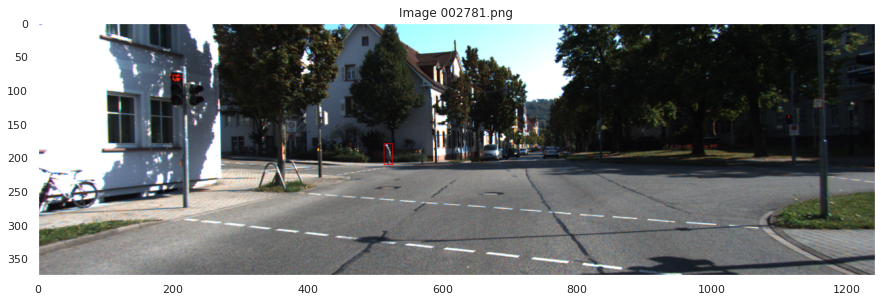

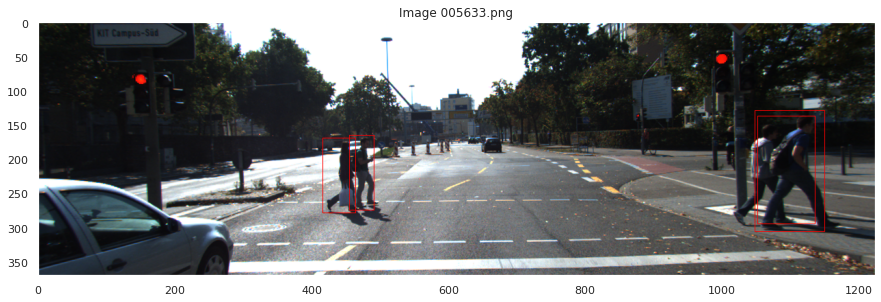

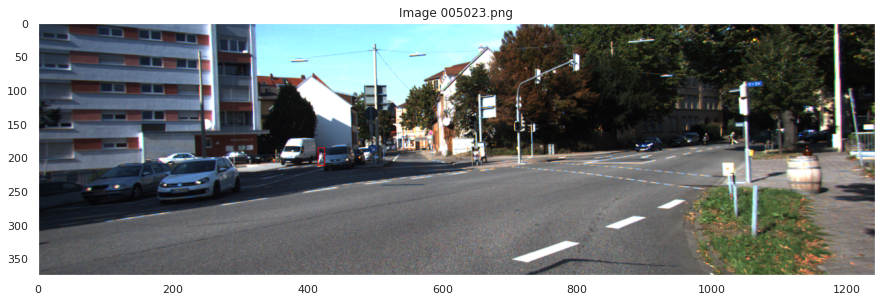

In [16]:
examples = ['002781.png', '005633.png', '005023.png']
imgs = [1, 2, 3]
new_imgs = imgs.copy()
for i, example in enumerate(examples):
#     opencv读出来的图片是 BGR，matplotlib默认图片是RGB，先转换一下
    imgs[i] = cv.imread(os.path.join(img_dir, example))
    new_imgs[i] = cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB)
    p_ids = results[example]
    
    for p_id in p_ids:
#         p_info = results[example][p_id]
        bbox = results[example][p_id]['bbox']
        cv.rectangle(new_imgs[i], (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255,0,0), thickness=1)
    
    plt.figure(figsize=(15,5))
    plt.grid(False)
    plt.title('Image %s'%example)
    plt.imshow(new_imgs[i])
    plt.show()

#### 行人块可视化

----------------------------------------
image: 002781.png
left, top, right, bottom of bbox: 513 180 526 211


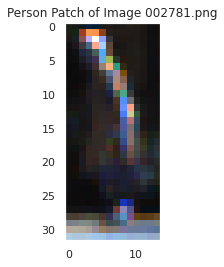

----------------------------------------
image: 005633.png
left, top, right, bottom of bbox: 1052 138 1136 295


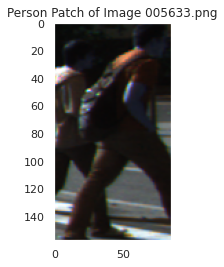

left, top, right, bottom of bbox: 1048 130 1150 306


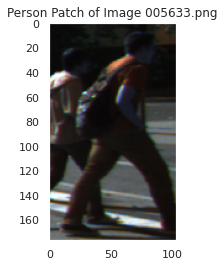

left, top, right, bottom of bbox: 455 166 491 275


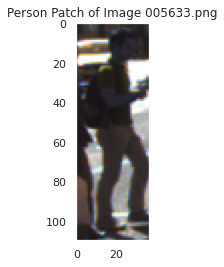

left, top, right, bottom of bbox: 416 170 464 279


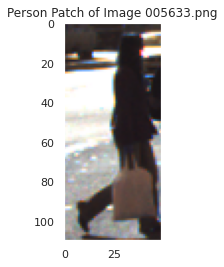

----------------------------------------
image: 005023.png
left, top, right, bottom of bbox: 415 186 425 212


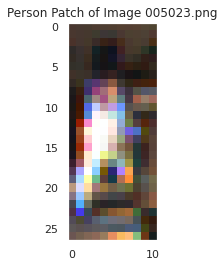

In [17]:
"""
矩形框大小不一，而且方差较大
把矩形框调整到统一大小
特征抽取器自己设计
"""
img_person_patches = []

for i, example in enumerate(examples):
    print('--'*20)
    print('image:', example)
    p_ids = results[example]
    for p_id in p_ids:
        bbox = results[example][p_id]['bbox']
        left, top, right, bottom = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        
        print('left, top, right, bottom of bbox:', left, top, right, bottom)
        img_person_patch = imgs[i][top:bottom+1, left:right+1, :]
        img_person_patches.append(img_person_patch)
                
        plt.grid(False)
        plt.title('Person Patch of Image %s'%example)
        plt.imshow(img_person_patch)
        plt.show()
    

#### 统一行人块尺寸，这部分可以放到数据加载前的transform

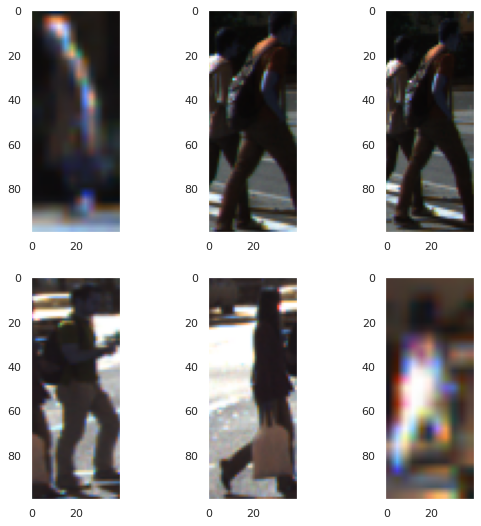

In [18]:
"""
该统一调大还是调小呢？行人块大小有限，调大了会比较模糊
    宽高比 - 2:5，像素（40,100）
    
"""
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(9, 9))

for i in range(2):
    for j in range(3):
        patch = img_person_patches[i*3 + j]
        patch = cv.resize(patch, (40, 100))
        ax[i][j].grid(False)        
        ax[i][j].imshow(patch)

plt.show()

# for patch in img_person_patches:
#     plt.figure(figsize=(2,5))
#     plt.imshow(patch)

#### 将行人块保存成单独图片和标签文件

In [19]:
start, end = 114, 202

height2idx = {}
idx2height = {}

for i in range(start, end):
    height2idx[i] = i - start
    idx2height[i-start] = i

print('height2idx:', height2idx)
print('idx2height:', idx2height)

height2idx: {114: 0, 115: 1, 116: 2, 117: 3, 118: 4, 119: 5, 120: 6, 121: 7, 122: 8, 123: 9, 124: 10, 125: 11, 126: 12, 127: 13, 128: 14, 129: 15, 130: 16, 131: 17, 132: 18, 133: 19, 134: 20, 135: 21, 136: 22, 137: 23, 138: 24, 139: 25, 140: 26, 141: 27, 142: 28, 143: 29, 144: 30, 145: 31, 146: 32, 147: 33, 148: 34, 149: 35, 150: 36, 151: 37, 152: 38, 153: 39, 154: 40, 155: 41, 156: 42, 157: 43, 158: 44, 159: 45, 160: 46, 161: 47, 162: 48, 163: 49, 164: 50, 165: 51, 166: 52, 167: 53, 168: 54, 169: 55, 170: 56, 171: 57, 172: 58, 173: 59, 174: 60, 175: 61, 176: 62, 177: 63, 178: 64, 179: 65, 180: 66, 181: 67, 182: 68, 183: 69, 184: 70, 185: 71, 186: 72, 187: 73, 188: 74, 189: 75, 190: 76, 191: 77, 192: 78, 193: 79, 194: 80, 195: 81, 196: 82, 197: 83, 198: 84, 199: 85, 200: 86, 201: 87}
idx2height: {0: 114, 1: 115, 2: 116, 3: 117, 4: 118, 5: 119, 6: 120, 7: 121, 8: 122, 9: 123, 10: 124, 11: 125, 12: 126, 13: 127, 14: 128, 15: 129, 16: 130, 17: 131, 18: 132, 19: 133, 20: 134, 21: 135, 22: 

In [20]:
def save_person_patch(img_dir, save_dir, flag=1):
    patch_name2height_idx = {'patch_name': [], 'height_idx': []}

    for example in results.keys():
        img = cv.imread(os.path.join(img_dir, example))
        p_ids = results[example]
        
        for j, p_id in enumerate(p_ids):
            idx = example.find('.png')
            person_patch_name = example[:idx] + '_' + str(j) + '.png'
            print('person_patch_name:', person_patch_name)

            if flag == 0:
                bbox = results[example][p_id]['bbox']
                left, top, right, bottom = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
                img_person_patch = img[top:bottom+1, left:right+1, :]
                cv.imwrite(os.path.join(save_dir, person_patch_name), img_person_patch)
                print('>'*3, person_patch_name, 'save!')
            else:
                height = results[example][p_id]['height']
                patch_name2height_idx['patch_name'].append(person_patch_name)                
                # print('\n'*2, '============= height:', height, '\n'*2)
                # print('\n'*2, '============= height*100:', height*100, '\n'*2)
                # print('\n'*2, '============= int(height*100):', int(height*100), '\n'*2)
                tmp_h = int(height*100) if int(height*100) >= 114 else 114
                patch_name2height_idx['height_idx'].append(height2idx[tmp_h])
                print('<'*3, person_patch_name, 'got!')

    return patch_name2height_idx
                

In [21]:
save_dir = '/mnt/sdb/public/data/jerry/kitti-person-patch'

pn2hi = save_person_patch(img_dir, save_dir)    # patch_name2height_idx

person_patch_name: 006159_0.png
<<< 006159_0.png got!
person_patch_name: 001758_0.png
<<< 001758_0.png got!
person_patch_name: 003786_0.png
<<< 003786_0.png got!
person_patch_name: 002885_0.png
<<< 002885_0.png got!
person_patch_name: 007157_0.png
<<< 007157_0.png got!
person_patch_name: 001049_0.png
<<< 001049_0.png got!
person_patch_name: 001049_1.png
<<< 001049_1.png got!
person_patch_name: 001049_2.png
<<< 001049_2.png got!
person_patch_name: 001049_3.png
<<< 001049_3.png got!
person_patch_name: 001049_4.png
<<< 001049_4.png got!
person_patch_name: 001049_5.png
<<< 001049_5.png got!
person_patch_name: 001049_6.png
<<< 001049_6.png got!
person_patch_name: 001049_7.png
<<< 001049_7.png got!
person_patch_name: 001049_8.png
<<< 001049_8.png got!
person_patch_name: 001049_9.png
<<< 001049_9.png got!
person_patch_name: 003502_0.png
<<< 003502_0.png got!
person_patch_name: 003502_1.png
<<< 003502_1.png got!
person_patch_name: 003502_2.png
<<< 003502_2.png got!
person_patch_name: 003502_3.

In [23]:
# 为什么只有一个元素，这是什么原因？
print("len(pn2hi['patch_name']):", len(pn2hi['patch_name']))
print('len(results):', len(results))

len(pn2hi['patch_name']): 4487
len(results): 1779


#### 分别保存训练集/测试集标签

In [24]:
# csv文件每行：img_name, height_distribution=(...)
def save_height_labels(flag='train', start=114, end=202, ratio=0.6):

    columns = []

    labels = {}
    labels['patch_name'] = pn2hi['patch_name']
    columns.append('patch_name')

    # 对于每个身高值，保存一个和 pn2hi['patch_name'] 等长的数组
    for height in range(start, end):
        labels[height] = []
        columns.append(height)

        for idx in pn2hi['height_idx']:
            height_ = idx2height[idx]

            if height == height_:
                labels[height].append(1.0)
            else:
                labels[height].append(0.0)

    df = pd.DataFrame(data=labels, columns=columns)
    df.to_csv('notebook/patch_height_labels.csv', index=False)

    # nums_total = len(pn2hi['height_idx'])
    # nums_train = int(ratio * nums_total)

    # df_train = df[0:nums_train, :]
    # df_test = df[nums_train:, :]
    # # 不保存行索引
    # # df_train.to_csv('notebook/train_patch_height_labels.csv', index=False)
    # # df_test.to_csv('notebook/test_patch_height_labels.csv', index=False)
    # df_train.to_csv('notebook/train_patch_height_labels.csv')
    # df_test.to_csv('notebook/test_patch_height_labels.csv')


In [25]:
save_height_labels()

In [62]:
import numpy as np

df = pd.read_csv('notebook/train_patch_height_labels.csv')
df.head()
df.iloc[0, 0]

'006159_0.png'

In [27]:
label = df.iloc[1, 1:]
label = np.array([label])
# label = label.astype('float').reshape(-1)
label
# print(la)
# label = np.array([label])

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=object)

#### 准备训练集和测试集

In [39]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision as tv
import torchvision.transforms as transforms

from skimage import io, transform

In [40]:
"""
定义本文数据集类、加载方式
    我的输入实际上是patch，一个patch对应一个身高/身高概率分布并不是KITTI原始图片，一个原始图片可能有多个patch，
"""
class PersonBBoxDataset(Dataset):
    def __init__(self, root_dir, label_file, transform=None):
        self.dataset_info = pd.read_csv(label_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataset_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataset_info.iloc[idx, 0])
        image = io.imread(img_name)
        print('\n\n inside __getitem__', image, '\n'*2)
        label = self.dataset_info.iloc[idx, 1:]
        label = np.array([label])
        label = label.astype('float').reshape(-1)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [41]:
# 定义数据变换（数据增强）操作
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # label不用变，因为它只是个身高(概率分布)，不涉及像素坐标
        return {'image': img, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}

transform_ = transforms.Compose([
    Rescale((100,40)),
    ToTensor()
])

In [42]:
trainset = PersonBBoxDataset(
    root_dir='/mnt/sdb/public/data/jerry/kitti-person-patch',
    label_file='notebook/train_patch_height_labels.csv',
    transform=transform_
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=192,
    shuffle=True,
    num_workers=6
)

testset = PersonBBoxDataset(
    root_dir='/mnt/sdb/public/data/jerry/kitti-person-patch',
    label_file='notebook/test_patch_height_labels.csv',    # 需要变换这里
    transform=transform_
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=192,
    shuffle=False,
    num_workers=6
)

### 身高预测模型

In [49]:
"""
这个神经网络应该是什么样的？使用已经有的还是自己设计？
    不应太大——层数不要太多
    卷积、池化、激活、全连接
输出概率分布还是单个数值？
"""

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        # 第一个参数，输入图片channel数；第二个参数，out维度；第三个参数，kernel size
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 24, 3)
        self.conv3 = nn.Conv2d(24, 36, 3)
        self.fc1 = nn.Linear(36*3*3, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

In [50]:
num_classes = 88
net = Net(num_classes)
print(net)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=324, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=88, bias=True)
)


#### 定义损失函数和优化器

In [51]:
from torch import optim

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

#### 开始训练

In [59]:
def train(trainloader, epochs, log_cycle=100):
    print('-'*10, 'Start training')
    for epoch in range(epochs):
        # 每个epoch中遍历log_cycle这么多样本的loss
        running_loss = .0

        for i, data in enumerate(trainloader):
            inputs, labels = data

            print('inputs:', inputs, 'label:', label)

            # 梯度清零，而不是权重清零
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # 反向传播，计算梯度，更新权重
            loss.backward()
            optimizer.step()

            running_loss += loss.data

            if i%log_cycle == log_cycle-1:
                print('[%d, %d] loss: %.3f' % (epoch+1, i+1, running_loss/log_cycle))
                running_loss = .0
        print('-'*10, 'Finished training')

In [60]:
train(trainloader, 5)

---------- Start training
inputs: image <class 'str'> label: [[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]]


TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not str

#### 测试模型

In [ ]:
def test(testloader):

    for data in testloader:
        images, labels = data
        outputs = net(images)

        """
        把标签转换为概率向量？还是取概率向量最大值？
        显然是前一种，用概率向量和身高相乘算身高
        """